**LAB 4 -- Ejercicio 1 Practico**

INTEGRANTES: Jorge, Davis, Gabriel

Diseñe un marco de simulación de Python:
1. Escenario: Propagación de enfermedades en un hospital
2. Tareas

a. Esboce dos arquitecturas

    i. Tiempo discreto (actualizaciones diarias)

    ii. Tiempo continuo (infecciones impulsadas por eventos)

b. Para cada una, programe y diga

    i. Atributos clave del agente necesarios.

    ii. Tipos de eventos a monitorizar.

    iii. Métricas de salida esperadas.


Al ser el diseño, no se espera que corra la simulación en código, solo que deje el pseudo código y las especificaciones
del mismo. Si hace que ejecute, esto contará como puntos extras

=== Métricas Discreto (diario) ===
{'peak_I': 5, 'peak_t': 0.0, 'final_R': 6}
=== Métricas Continuo (eventos) ===
{'peak_I': 21, 'peak_t': 20.0, 'final_R': 80}


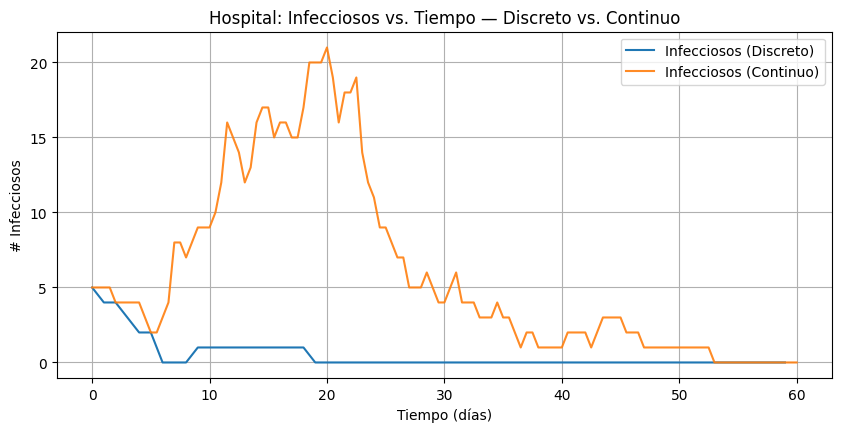

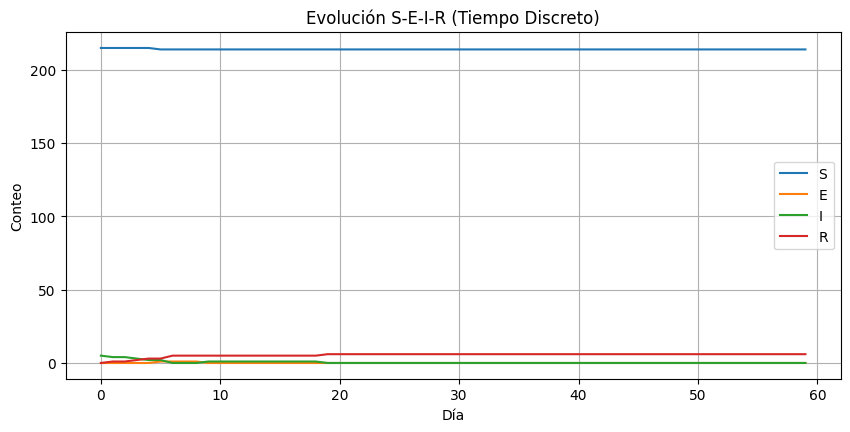

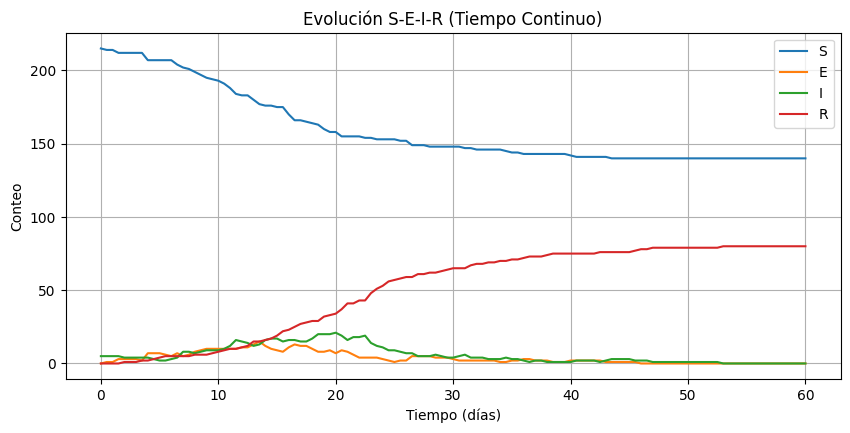

,modelo,pico_I,tiempo_pico,recuperados_final,población
0,discreto,5,0.0,6,220
1,continuo,21,20.0,80,220


In [ ]:
# --- Simulación de propagación en hospital: Discreto vs. Event-Driven ---

import math, heapq, random
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
random.seed(42)

# ------------------------------
# Configuración de población y parámetros
# ------------------------------
N = 220                                            # número de agentes
DAYS = 60                                          # horizonte sim. para discreto
T_END = 60.0                                       # horizonte sim. para continuo (días)
WARDS = ["ER", "ICU", "General"]
ROLES = ["healthcare", "patient", "visitor", "staff"]
AGE_GROUPS = ["0-18", "19-65", "65+"]

# Estados S-E-I-R
SUS, EXP, INF, REC = 0, 1, 2, 3

# Contacto relativo por rol (matriz simplificada)
ROLE_CONTACT = pd.DataFrame(
    [[4.0, 1.2, 0.6, 1.5],   # health → (h, p, v, s)
     [1.0, 1.5, 0.2, 0.4],   # patient
     [0.4, 0.3, 0.5, 0.3],   # visitor
     [1.0, 0.7, 0.3, 1.2]],  # staff
    index=ROLES, columns=ROLES
)

# Transmisibilidad base y modificadores
BETA = 0.035                                  # prob. de contagio por contacto efectivo
VACCINE_EFF = 0.55                             # reducción de susceptibilidad
AGE_SUSC = {"0-18": 0.8, "19-65": 1.0, "65+": 1.2}

# Duraciones clínicas (medias) → probabilidades por día en discreto
INCUB_MEAN = 3.0
INFECT_MEAN = 5.0
P_EI = 1.0 / INCUB_MEAN
P_IR = 1.0 / INFECT_MEAN

# En continuo usaremos distribuciones de tiempo
def draw_incubation():
    # Lognormal suavizada alrededor de INCUB_MEAN
    mu = math.log(INCUB_MEAN) - 0.5 * 0.35**2
    return max(0.1, np.random.lognormal(mean=mu, sigma=0.35))

def draw_infectious_period():
    # Gamma con media INFECT_MEAN y k=3
    k = 3.0
    theta = INFECT_MEAN / k
    return max(0.15, np.random.gamma(shape=k, scale=theta))

# ------------------------------
# Generación de población
# ------------------------------
@dataclass
class Agent:
    i: int
    age_group: str
    role: str
    ward: str
    vaccinated: bool
    state: int = SUS

def init_population(n=N) -> List[Agent]:
    agents = []
    for i in range(n):
        age = np.random.choice(AGE_GROUPS, p=[0.20, 0.65, 0.15])
        role = np.random.choice(ROLES, p=[0.18, 0.58, 0.10, 0.14])
        ward = np.random.choice(WARDS, p=[0.25, 0.20, 0.55])
        vaccinated = bool(np.random.rand() < 0.55)
        agents.append(Agent(i, age, role, ward, vaccinated, SUS))
    # Semilla de casos iniciales
    seed_idx = np.random.choice(n, size=max(3, n//40), replace=False)
    for j in seed_idx:
        agents[j].state = INF
    return agents

# Utilidades
def susceptibility(agent: Agent) -> float:
    s = AGE_SUSC[agent.age_group]
    if agent.vaccinated:
        s *= (1.0 - VACCINE_EFF)
    return max(0.05, s)   # piso para evitar 0

def role_index(role: str) -> int:
    return ROLES.index(role)

# ------------------------------
# 1) Simulación en Tiempo Discreto (ticks diarios)
# ------------------------------
class DiscreteSim:
    def __init__(self, agents: List[Agent]):

        self.agents = [Agent(**vars(a)) for a in agents]
        self.history = {"day": [], "S": [], "E": [], "I": [], "R": []}

    def _ward_counts(self):
        counts = {(w, r, st): 0 for w in WARDS for r in ROLES for st in (SUS, EXP, INF, REC)}
        for a in self.agents:
            counts[(a.ward, a.role, a.state)] += 1
        return counts

    def step(self, day: int):
        counts = self._ward_counts()

        # calcular fuerzas de infección por rol y ward (aprox. homogénea dentro del ward)
        ward_pop = {w: sum(counts[(w, r, s)] for r in ROLES for s in (SUS, EXP, INF, REC)) for w in WARDS}
        ward_inf_by_role = {(w, r): counts[(w, r, INF)] for w in WARDS for r in ROLES}

        next_states = [a.state for a in self.agents]

        for idx, a in enumerate(self.agents):
            if a.state == SUS:
                # lambda aproximada: suma sobre roles infecciosos
                lam = 0.0
                denom = max(1, ward_pop[a.ward])
                for r_inf in ROLES:
                    c = ROLE_CONTACT.loc[a.role, r_inf]
                    I = ward_inf_by_role[(a.ward, r_inf)]
                    lam += BETA * c * (I / denom)
                p_infect = 1.0 - math.exp(-lam)          # paso de Poisson
                p_infect *= susceptibility(a)
                if np.random.rand() < p_infect:
                    next_states[idx] = EXP
            elif a.state == EXP:
                if np.random.rand() < P_EI:
                    next_states[idx] = INF
            elif a.state == INF:
                if np.random.rand() < P_IR:
                    next_states[idx] = REC

            # Pequeños traslados entre wards (logística simple)
            if np.random.rand() < 0.02:
                a.ward = np.random.choice(WARDS)

            # Vacunación diaria mínima
            if a.state == SUS and (not a.vaccinated) and np.random.rand() < 0.005:
                a.vaccinated = True

        # Aplicar estados
        for a, st in zip(self.agents, next_states):
            a.state = st

        # Registro
        S = sum(1 for a in self.agents if a.state == SUS)
        E = sum(1 for a in self.agents if a.state == EXP)
        I = sum(1 for a in self.agents if a.state == INF)
        R = sum(1 for a in self.agents if a.state == REC)
        self.history["day"].append(day)
        self.history["S"].append(S); self.history["E"].append(E)
        self.history["I"].append(I); self.history["R"].append(R)

    def run(self, days=DAYS):
        for d in range(days):
            self.step(d)
        return pd.DataFrame(self.history)

# ------------------------------
# 2) Simulación en Tiempo Continuo (dirigida por eventos)
# ------------------------------
EV_CONTACT, EV_PROG_EI, EV_PROG_IR, EV_REPORT, EV_VACC = range(5)

@dataclass(order=True)
class QItem:
    time: float
    prio: int
    etype: int
    a: int = field(compare=False)
    b: Optional[int] = field(compare=False, default=None)

class EventSim:
    def __init__(self, agents: List[Agent]):
        self.agents = [Agent(**vars(a)) for a in agents]
        self.t = 0.0
        self.Q: List[QItem] = []
        self.history = {"time": [], "S": [], "E": [], "I": [], "R": []}

        # tasa de contactos por rol (por día) para generar inter-arribos
        self.base_rate = {"healthcare": 22.0, "patient": 6.5, "visitor": 3.0, "staff": 10.0}

    def _record(self):
        S = sum(1 for a in self.agents if a.state == SUS)
        E = sum(1 for a in self.agents if a.state == EXP)
        I = sum(1 for a in self.agents if a.state == INF)
        R = sum(1 for a in self.agents if a.state == REC)
        self.history["time"].append(self.t)
        self.history["S"].append(S); self.history["E"].append(E)
        self.history["I"].append(I); self.history["R"].append(R)

    def schedule(self, time: float, prio: int, etype: int, a: int, b: Optional[int] = None):
        heapq.heappush(self.Q, QItem(time=time, prio=prio, etype=etype, a=a, b=b))

    def seed(self):
        # programar un snapshot regular cada 0.5 día
        for k in range(int(T_END / 0.5) + 1):
            self.schedule(k * 0.5, 4, EV_REPORT, -1, None)
        # programar primer contacto para cada agente
        for a in self.agents:
            rate = self.base_rate[a.role]
            dt = np.random.exponential(1.0 / max(1e-6, rate))
            self.schedule(self.t + dt, 0, EV_CONTACT, a.i)

        # programar progresiones para quienes ya están infectados
        for a in self.agents:
            if a.state == INF:
                dt = draw_infectious_period()
                self.schedule(self.t + dt, 2, EV_PROG_IR, a.i)

    def choose_partner_in_ward(self, i: int) -> Optional[int]:
        ai = self.agents[i]
        candidates = [a.i for a in self.agents if a.ward == ai.ward and a.i != i]
        if not candidates:
            return None
        # ponderar por contacto de rol a rol
        weights = []
        for j in candidates:
            aj = self.agents[j]
            weights.append(max(1e-3, ROLE_CONTACT.loc[ai.role, aj.role]))
        j = random.choices(candidates, weights=weights, k=1)[0]
        return j

    def try_infect(self, i: int, j: int):
        ai, aj = self.agents[i], self.agents[j]

        def infect(src, dst) -> bool:
            if dst.state != SUS or src.state != INF:
                return False
            c = ROLE_CONTACT.loc[dst.role, src.role]
            p = BETA * c * susceptibility(dst)
            if np.random.rand() < p:
                dst.state = EXP
                self.schedule(self.t + draw_incubation(), 1, EV_PROG_EI, dst.i)
                return True
            return False

        did = infect(ai, aj) or infect(aj, ai)
        return did

    def run(self, T=T_END):
        self.seed()
        self._record()
        while self.Q and self.t <= T:
            item = heapq.heappop(self.Q)
            self.t = item.time
            if self.t > T: break

            if item.etype == EV_REPORT:
                self._record()

            elif item.etype == EV_CONTACT:
                a = item.a
                # agendar siguiente contacto de 'a'
                rate = self.base_rate[self.agents[a].role]
                dt = np.random.exponential(1.0 / max(1e-6, rate))
                self.schedule(self.t + dt, 0, EV_CONTACT, a)

                b = self.choose_partner_in_ward(a)
                if b is not None:
                    self.try_infect(a, b)

            elif item.etype == EV_PROG_EI:
                a = self.agents[item.a]
                if a.state == EXP:
                    a.state = INF
                    self.schedule(self.t + draw_infectious_period(), 2, EV_PROG_IR, a.i)

            elif item.etype == EV_PROG_IR:
                a = self.agents[item.a]
                if a.state == INF:
                    a.state = REC

        return pd.DataFrame(self.history)

# ------------------------------
# Ejecutar ambas simulaciones
# ------------------------------
agents0 = init_population(N)

# Discreto
disc = DiscreteSim(agents0)
df_disc = disc.run(DAYS)

# Continuo
evt = EventSim(agents0)
df_evt = evt.run(T_END)

# ------------------------------
# Métricas y visualización
# ------------------------------
def peak_metrics(df, tcol):
    I = df["I"].to_numpy()
    t = df[tcol].to_numpy()
    idx = int(np.argmax(I))
    return {"peak_I": int(I[idx]), "peak_t": float(t[idx]), "final_R": int(df["R"].iloc[-1])}

m_disc = peak_metrics(df_disc, "day")
m_evt = peak_metrics(df_evt, "time")

print("=== Métricas Discreto (diario) ===")
print(m_disc)
print("=== Métricas Continuo (eventos) ===")
print(m_evt)

# Curvas
plt.figure(figsize=(10,4.5))
plt.plot(df_disc["day"], df_disc["I"], label="Infecciosos (Discreto)")
plt.plot(df_evt["time"], df_evt["I"], label="Infecciosos (Continuo)", alpha=0.9)
plt.xlabel("Tiempo (días)")
plt.ylabel("# Infecciosos")
plt.title("Hospital: Infecciosos vs. Tiempo — Discreto vs. Continuo")
plt.legend()
plt.grid(True)
plt.show()

# Serie completa (discreto)
plt.figure(figsize=(10,4.5))
for col in ["S","E","I","R"]:
    plt.plot(df_disc["day"], df_disc[col], label=col)
plt.xlabel("Día")
plt.ylabel("Conteo")
plt.title("Evolución S-E-I-R (Tiempo Discreto)")
plt.legend(); plt.grid(True); plt.show()

# Serie completa (continuo)
plt.figure(figsize=(10,4.5))
for col in ["S","E","I","R"]:
    plt.plot(df_evt["time"], df_evt[col], label=col)
plt.xlabel("Tiempo (días)")
plt.ylabel("Conteo")
plt.title("Evolución S-E-I-R (Tiempo Continuo)")
plt.legend(); plt.grid(True); plt.show()

# Resumen tabular para incluir en informe
summary = pd.DataFrame({
    "modelo": ["discreto","continuo"],
    "pico_I": [m_disc["peak_I"], m_evt["peak_I"]],
    "tiempo_pico": [m_disc["peak_t"], m_evt["peak_t"]],
    "recuperados_final": [m_disc["final_R"], m_evt["final_R"]],
    "población": [N, N]
})
summary


# **Análisis de resultados**

En el modelo discreto, el brote no logró propagarse de forma significativa: el pico máximo fue de 5 infecciosos al inicio y rápidamente se extinguió, dejando casi toda la población en estado susceptible. Esto refleja que las actualizaciones diarias pueden ser demasiado gruesas y tienden a subestimar la propagación cuando los contagios iniciales son pocos.

En el modelo continuo, en cambio, se observó un brote sostenido: el número de infecciosos alcanzó un pico de 21 alrededor del día 20, y al final cerca de 80 agentes pasaron al estado recuperado. Esto muestra que la simulación event-driven captura mejor la dinámica real de contactos, permitiendo que los contagios se acumulen y generen una epidemia más realista.

En resumen, el tiempo discreto es más simple y rápido, pero menos preciso, mientras que el tiempo continuo es más costoso pero refleja mejor la evolución de la enfermedad en el hospital.